# YoY Growth Decomposition Analysis (Retail)

## Overview
This notebook demonstrates how to decompose year-over-year (YoY) sales growth using synthetic retail data and a simple, interpretable machine-learning model.

Business Challenge:
1. Identify which drivers truly contributed to YoY growth and where the business should focus investment
2. Separate driver potential from realized impact using ML approach
3. Communicate results in a way that is intuitive and actionable for business stakeholders

Approach: Apply log and log-difference transformations with a linear regression model to:
1. Explain YoY sales growth in a mathematically consistent way
2. Quantify each driver’s contribution to total growth
3. Produce a clear, additive decomposition that supports decision-making

## Table of Contents

1. [Data Generation](#1-data-generation)
2. [Feature Engineering](#2-feature-engineering)
3. [Model Training](#3-model-training)
4. [Model Evaluation](#4-model-evaluation)
5. [Growth Decomposition](#5-growth-decomposition)
6. [Visualization](#6-visualization)
   - [6.1 Actual vs Predicted YoY Growth](#61-actual-vs-predicted-yoy-growth)
   - [6.2 Waterfall Chart: Driver Contributions](#62-waterfall-chart-driver-contributions)
   - [6.3 Accounting Table Allocation Chart](#63-accounting-table-allocation-chart)




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm

# Configure pandas to display full results (no truncation)
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)    # Show all columns
pd.set_option('display.width', None)           # Auto-detect width
pd.set_option('display.max_colwidth', None)    # Show full column content
pd.set_option('display.expand_frame_repr', False)  # Don't wrap to multiple pages

# Disable scientific notation and format numbers appropriately
# Large numbers (>= 10): show as integers with commas
# Medium numbers (0.1 to 10): show with 3 decimals without commas (for price_index, etc.)
# Small numbers (< 0.1): show with 6 decimals
def format_number(x):
    if pd.isna(x):
        return str(x)
    abs_x = abs(x)
    if abs_x >= 10:
        return f'{x:,.0f}'
    elif abs_x >= 0.1:
        return f'{x:.3f}'  # 3 decimals, no commas for medium numbers
    else:
        return f'{x:.6f}'

pd.set_option('display.float_format', format_number)
np.set_printoptions(suppress=True)

np.random.seed(2025)

## 1. Data Generation <a class="anchor" id="1-data-generation"></a>

Generate 2-year weekly synthetic retail data (104 weeks) with the following features:
- `media_spend`: weekly advertising spend ($)
- `promo_depth`: promotion/discount depth (fraction)
- `price_index`: normalized price level
- `store_count`: active stores (integer)
- `instock_rate`: in-stock availability (0-1)
- `customer_satisfaction_rate`: customer satisfaction rate/score (0-1)


In [13]:
# ============================================================
# 1) Generate RAW retail data (2 years weekly)
#    Raw columns requested:
#    week, sales, media_spend, promo_depth, price_index,
#    store_count (int), instock_rate, customer_satisfaction_rate
# ============================================================

# Weekly Mondays from 2023-01-02 for 104 weeks (covers 2023 & 2024)
dates = pd.date_range("2023-01-02", periods=104, freq="W-MON")
df = pd.DataFrame({"week": dates})
df["year"] = df["week"].dt.year

# A stable week index so "t-52" aligns exactly with last year's same week
df["week_idx"] = np.arange(len(df))
df["woy"] = (df["week_idx"] % 52) + 1  # 1..52 for readability
woy_idx = np.arange(52)

# --- We will generate sales with a repeating seasonality pattern by week-of-year ---
# (In feature engineering below, we'll recreate "seasonality" as an engineered column.)
seasonality_by_woy = (
    0.16 * np.sin(2 * np.pi * woy_idx / 52) +
    0.10 * np.cos(2 * np.pi * woy_idx / 26)
)
holiday_bump = np.zeros(52)
holiday_bump[47] += 0.20  # holiday peak around woy=48
holiday_bump[25] += 0.08  # mid-year event
seasonality_by_woy = seasonality_by_woy + holiday_bump

# --- Year 1 feature levels (by woy) ---
media_y1  = np.clip(220_000 + 50_000*np.sin(2*np.pi*woy_idx/52) + np.random.normal(0, 15_000, 52), 90_000, None)
promo_y1  = np.clip(0.06 + 0.02*np.sin(2*np.pi*woy_idx/52 + 0.7) + np.random.normal(0, 0.006, 52), 0.0, 0.30)
price_y1  = np.clip(1.00 + 0.008*np.cos(2*np.pi*woy_idx/52 - 0.2) + np.random.normal(0, 0.003, 52), 0.97, 1.05)
stores_y1 = np.clip(110 + 2*np.sin(2*np.pi*woy_idx/52 + 0.3) + np.random.normal(0, 1.2, 52), 95, 125)
inst_y1   = np.clip(0.94 + 0.01*np.cos(2*np.pi*woy_idx/52 + 0.4) + np.random.normal(0, 0.006, 52), 0.85, 0.99)
csat_y1   = np.clip(0.82 + 0.01*np.sin(2*np.pi*woy_idx/52 - 0.5) + np.random.normal(0, 0.006, 52), 0.75, 0.95)

# --- Independent YoY changes by woy (ideal for lecture: easy signs + good fit) ---
dlog_media_woy  = np.clip(np.random.normal(0.10, 0.06, 52), -0.05, 0.25)   # ~ +10% YoY media
d_promo_woy     = np.clip(np.random.normal(0.01, 0.012, 52), -0.03, 0.06)  # +1pp avg (fraction units)
dlog_price_woy  = np.clip(np.random.normal(0.03, 0.015, 52), 0.00, 0.08)   # ~ +3% YoY price
dlog_stores_woy = np.clip(np.random.normal(0.04, 0.02, 52), -0.02, 0.10)   # ~ +4% YoY stores
d_instock_woy   = np.clip(np.random.normal(0.01, 0.006, 52), -0.02, 0.03)  # +1pp avg
d_csat_woy      = np.clip(np.random.normal(0.015, 0.008, 52), -0.02, 0.05) # +1.5pp avg

# --- Build Year 2 levels from Year 1 + YoY changes ---
media_y2 = np.expm1(np.log1p(media_y1) + dlog_media_woy)
promo_y2 = np.clip(promo_y1 + d_promo_woy, 0.0, 0.35)
price_y2 = np.exp(np.log(price_y1) + dlog_price_woy)
stores_y2 = np.exp(np.log(stores_y1) + dlog_stores_woy)
inst_y2 = np.clip(inst_y1 + d_instock_woy, 0.85, 0.99)
csat_y2 = np.clip(csat_y1 + d_csat_woy, 0.75, 0.95)

# Fill weekly series (2023 uses *_y1, 2024 uses *_y2)
is_2023 = df["year"].eq(2023).to_numpy()
woy0 = (df["woy"] - 1).to_numpy()

media = np.where(is_2023, media_y1[woy0], media_y2[woy0])
promo = np.where(is_2023, promo_y1[woy0], promo_y2[woy0])
price = np.where(is_2023, price_y1[woy0], price_y2[woy0])
stores = np.where(is_2023, stores_y1[woy0], stores_y2[woy0])
instock = np.where(is_2023, inst_y1[woy0], inst_y2[woy0])
csat = np.where(is_2023, csat_y1[woy0], csat_y2[woy0])

# Enforce requested raw formats
media_spend = np.round(media).astype(int)
store_count = np.round(stores).astype(int)

# --- Generate Sales with a log-linear DGP (explainable + a bit noisy) ---
true = {
    "b_media":   0.30,   # media helps
    "b_promo":   0.80,   # promo helps
    "b_price":  -1.00,   # higher price reduces sales
    "b_stores":  0.60,   # more stores increases sales
    "b_instock": 0.70,   # better availability increases sales
    "b_csat":    0.50,   # better CSAT increases sales
    "trend":     0.0005  # small underlying growth trend
}

log_media = np.log1p(media_spend)
log_price = np.log(price)
log_stores = np.log(store_count)

seasonality = seasonality_by_woy[woy0]
noise = np.random.normal(0, 0.01, size=len(df))  # slightly larger residual, still good fit

base_level = 11.7  # sets sales level scale

log_sales_raw = (
    base_level
    + seasonality
    + true["trend"] * df["week_idx"].to_numpy()
    + true["b_media"]   * log_media
    + true["b_promo"]   * promo
    + true["b_price"]   * log_price
    + true["b_stores"]  * log_stores
    + true["b_instock"] * instock
    + true["b_csat"]    * csat
    + noise
)

# Calibrate mean YoY (geometric) across 2024 to ~10%
target_mean_dlog = np.log(1.10)
dlog_initial = log_sales_raw[52:] - log_sales_raw[:52]
shift = target_mean_dlog - dlog_initial.mean()

log_sales = log_sales_raw.copy()
log_sales[52:] += shift
sales = np.exp(log_sales)

# Raw dataset (exact columns requested)
raw_df = pd.DataFrame({
    "week": df["week"],
    "sales": sales,
    "media_spend": media_spend,
    "promo_depth": promo,
    "price_index": price,
    "store_count": store_count,
    "instock_rate": instock,
    "customer_satisfaction_rate": csat
})

In [3]:
print("RAW DATA (head):")
print(raw_df.head(8))
print("counts of df: ",len(raw_df))
min_week = raw_df["week"].min()
max_week = raw_df["week"].max()
print(f"Min week: {min_week}, Max week: {max_week}")


print("\nRAW FEATURE DEFINITIONS:")
print("- week: weekly date (Mondays)")
print("- sales: total weekly sales")
print("- media_spend: weekly advertising spend ($)")
print("- promo_depth: promotion/discount depth (fraction, 0.10 = 10% off)")
print("- price_index: normalized price level (1.03 means ~3% higher vs reference)")
print("- store_count: active stores (integer)")
print("- instock_rate: in-stock availability (0-1)")
print("- customer_satisfaction_rate: customer satisfaction rate/score (0-1)")

RAW DATA (head):
        week       sales  media_spend  promo_depth  price_index  store_count  instock_rate  customer_satisfaction_rate
0 2023-01-02 275,200,055       218614     0.068855        1.010          112         0.935                       0.814
1 2023-01-09 287,749,477       237041     0.067062        1.007          109         0.948                       0.817
2 2023-01-16 278,394,999       210383     0.081584        1.007          109         0.952                       0.815
3 2023-01-23 293,087,918       227779     0.084513        1.011          111         0.941                       0.819
4 2023-01-30 298,763,252       241725     0.072282        1.003          112         0.952                       0.807
5 2023-02-06 309,302,080       280608     0.078355        1.010          114         0.939                       0.827
6 2023-02-13 306,101,349       274062     0.082155        1.011          113         0.940                       0.812
7 2023-02-20 300,350,398       

## 2. Feature Engineering <a class="anchor" id="2-feature-engineering"></a>
When features (eg.media spend) are modeled in **log** levels, the coefficient represents an elasticity: a 1% higher media level is associated with a β% higher sales level. When features (eg.media spend) are modeled in **log differences**, the coefficient represents how changes in media over time contribute to changes in sales growth. In this notebook, we use log differences because the business question focuses on explaining year-over-year growth rather than long-run sales levels.

 - log(level) makes coefficients interpretable as % changes and stabilizes variance
 - Δlog(level) aligns with YoY growth decomposition and helps contributions add up cleanly

We transform features based on how they influence growth. *Scalable quantities* such as media spend, prices, and store count are modeled using log differences so their effects are interpreted as proportional changes aligned with YoY growth. *Bounded rate* variables such as promotion depth, in-stock rate, and customer satisfaction are modeled using raw YoY differences because percentage-point changes are more meaningful for these metrics. Using these transformations ensures interpretability, comparability across scale, and clean growth decomposition.

Because the target is defined as year-over-year log sales growth, stable seasonal patterns cancel out by construction. To keep the demo focused on business drivers and growth decomposition mechanics, we intentionally exclude explicit seasonality controls.

In [14]:

# ============================================================
# 2) Feature engineering:
#    year, woy, seasonality, logs, deltas (Δ) and delta-logs (Δlog)
# ============================================================
df2 = raw_df.copy()
df2["year"] = df2["week"].dt.year
df2["week_idx"] = np.arange(len(df2))
df2["woy"] = (df2["week_idx"] % 52) + 1

# Seasonality engineered from woy (known in this synthetic demo)
woy0 = (df2["woy"] - 1).to_numpy()
df2["seasonality"] = seasonality_by_woy[woy0]

# Logs for level variables
df2["log_sales"]  = np.log(df2["sales"])
df2["log_media"]  = np.log1p(df2["media_spend"]) # media_spend can be 0. if 0, log1p(0) = 0
df2["log_price"]  = np.log(df2["price_index"])
df2["log_stores"] = np.log(df2["store_count"])

# YoY lag (52 weeks)
lag = 52
for c in ["log_sales","log_media","promo_depth","log_price","log_stores","instock_rate","customer_satisfaction_rate"]:
    df2[f"{c}_lag52"] = df2[c].shift(lag)

# Target: YoY growth in log units (≈ YoY % for typical ranges)
df2["dlog_sales_yoy"] = df2["log_sales"] - df2["log_sales_lag52"]

# Features: mixed transforms
df2["dlog_media"]  = df2["log_media"] - df2["log_media_lag52"]                 # Δlog
df2["d_promo"]     = df2["promo_depth"] - df2["promo_depth_lag52"]             # Δ (pp-style)
df2["dlog_price"]  = df2["log_price"] - df2["log_price_lag52"]                 # Δlog (per request)
df2["dlog_stores"] = df2["log_stores"] - df2["log_stores_lag52"]               # Δlog
df2["d_instock"]   = df2["instock_rate"] - df2["instock_rate_lag52"]           # Δ (pp-style)
df2["d_csat"]      = df2["customer_satisfaction_rate"] - df2["customer_satisfaction_rate_lag52"]  # Δ (pp-style)

# Keep only 2024 rows where YoY is defined
yoy = df2[df2["week_idx"] >= 52].copy()



In [15]:
print("\nENGINEERED DATA (head):")
cols_to_show = [
    "week","year","woy",#"seasonality",
    "sales","log_sales","dlog_sales_yoy",
    "media_spend","log_media","dlog_media",
    "promo_depth","d_promo",
    "price_index","log_price","dlog_price",
    "store_count","log_stores","dlog_stores",
    "instock_rate","d_instock",
    "customer_satisfaction_rate","d_csat"
]
print(yoy[cols_to_show].head(6))

print("counts of yoy: ",len(yoy))
min_week = yoy["week"].min()
max_week = yoy["week"].max()
print(f"Min week: {min_week}, Max week: {max_week}")

print("\nENGINEERED FEATURE DEFINITIONS (key ones):")
print("- log_sales: log(sales)")
print("- dlog_sales_yoy: log(sales_t) - log(sales_{t-52}) ~ YoY % sales growth (log units)")
print("- dlog_media/dlog_price/dlog_stores: YoY % changes (approx) in scalable variables")
print("- d_promo/d_instock/d_csat: YoY changes in rates (0.01 = +1 percentage point)")


ENGINEERED DATA (head):
         week  year  woy       sales  log_sales  dlog_sales_yoy  media_spend  log_media  dlog_media  promo_depth   d_promo  price_index  log_price  dlog_price  store_count  log_stores  dlog_stores  instock_rate  d_instock  customer_satisfaction_rate    d_csat
52 2024-01-01  2024    1 307,121,376         20           0.110       235343         12    0.073736     0.093550  0.024695        1.057   0.055184    0.045721          119       4.779     0.060625         0.949   0.013800                       0.829  0.015408
53 2024-01-08  2024    2 315,381,889         20        0.091694       250225         12    0.054127     0.066309 -0.000753        1.022   0.021656    0.014987          115       4.745     0.053584         0.948  -0.000212                       0.829  0.012384
54 2024-01-15  2024    3 293,531,393         19        0.052944       215368         12    0.023418     0.093486  0.011903        1.050   0.048931    0.041583          114       4.736     0.04485

In [16]:
# Show head of engineered YoY features (same columns as in engineering print above)
display_cols = [
    "dlog_sales_yoy","dlog_media","d_promo","dlog_price","dlog_stores","d_instock","d_csat"
]
display(yoy[display_cols].head(8))  # show more if you like

,dlog_sales_yoy,dlog_media,d_promo,dlog_price,dlog_stores,d_instock,d_csat
52,0.110,0.073736,0.024695,0.045721,0.060625,0.013800,0.015408
53,0.091694,0.054127,-0.000753,0.014987,0.053584,-0.000212,0.012384
54,0.052944,0.023418,0.011903,0.041583,0.044851,0.007767,0.029653
55,0.104,0.112,-0.003767,0.005143,0.017858,0.024650,0.016217
56,0.063760,0.107,0.006019,0.030485,0.026433,0.012189,-0.001624
57,0.076849,0.108,-0.010734,0.056864,0.042925,0.007796,0.031380
58,0.155,0.234,0.009005,0.002776,0.060104,0.011068,0.004003
59,0.042875,0.068709,-0.000312,0.035888,0.052186,0.002682,0.030606


In [17]:
# Select rows where week is either '2024-01-01' or '2023-01-02'
yoy_example = raw_df[raw_df['week'].isin(['2024-01-01', '2023-01-02'])]
yoy_example


C:\Users\cheng\AppData\Local\Temp\ipykernel_34616\1269569833.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  yoy_example = raw_df[raw_df['week'].isin(['2024-01-01', '2023-01-02'])]


,week,sales,media_spend,promo_depth,price_index,store_count,instock_rate,customer_satisfaction_rate
0,2023-01-02,"275,200,055",218614,0.068855,1.010,112,0.935,0.814
52,2024-01-01,"307,121,376",235343,0.093550,1.057,119,0.949,0.829


## 3. Model Training <a class="anchor" id="3-model-training"></a>

In [ ]:

# ============================================================
# 3) Train/test split and fit linear regression
# ============================================================
feature_cols = ["dlog_media","d_promo","dlog_price","dlog_stores","d_instock","d_csat"]
target_col = "dlog_sales_yoy"

# Time-based split (lecture friendly): first 40 weeks of 2024 train, last 12 test
train = yoy.iloc[:40].copy()
test  = yoy.iloc[40:].copy()

X_train, y_train = train[feature_cols], train[target_col]
X_test,  y_test  = test[feature_cols],  test[target_col]

model = LinearRegression()
model.fit(X_train, y_train)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


## 4. Model Evaluation <a class="anchor" id="4-model-evaluation"></a>

In [19]:

# ============================================================
# 4) Model evaluation (stat + business meaning)
# ============================================================
def rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

def to_yoy_pct(dlog):
    # convert Δlog back to a YoY percent (exact)
    return (np.exp(dlog) - 1) * 100

yhat_train = model.predict(X_train)
yhat_test  = model.predict(X_test)

metrics = pd.DataFrame({
    "Split": ["Train","Test"],
    "RMSE (Δlog units)": [rmse(y_train, yhat_train), rmse(y_test, yhat_test)],
    "MAE (Δlog units)": [float(mean_absolute_error(y_train, yhat_train)), float(mean_absolute_error(y_test, yhat_test))],
    "R^2": [float(r2_score(y_train, yhat_train)), float(r2_score(y_test, yhat_test))],
    "RMSE (YoY % pts)": [rmse(to_yoy_pct(y_train), to_yoy_pct(yhat_train)),
                         rmse(to_yoy_pct(y_test),  to_yoy_pct(yhat_test))]
})
print("\nMODEL EVALUATION:")
print(metrics)


MODEL EVALUATION:
   Split  RMSE (Δlog units)  MAE (Δlog units)   R^2  RMSE (YoY % pts)
0  Train           0.014258          0.011225 0.782             1.555
1   Test           0.012114          0.008904 0.825             1.339


Model evaluation interpretation

- **Overall fit looks strong and consistent**. The model performs similarly on Train and Test, which suggests it generalizes well and is not overfitting.

- **RMSE (YoY % pts)** is the most intuitive metric here.
    - Train RMSE = 1.56 pp, Test RMSE = 1.34 pp
    - Meaning: on average, the model’s predicted YoY sales growth is off by about ~1.3–1.6 percentage points.
    - Example: if actual YoY growth is 10%, the model typically predicts something like 8.6%–11.4%.

- **MAE** confirms similar accuracy.
    - Train MAE = 0.0112 Δlog, Test MAE = 0.0089 Δlog
    - In plain terms, the “typical miss” is around ~0.9–1.1 percentage points in YoY growth.

- **R²** indicates good explanatory power.
    - Train R² = 0.78, Test R² = 0.83
    - Interpretation: the model explains roughly ~78–83% of the week-to-week variation in YoY sales growth in this dataset. The remaining ~17–22% is “unexplained,” which can reflect noise, unmeasured drivers, or factors not included in the model.

Bottom line: This model is accurate enough to support a YoY growth decomposition and to compare the relative contribution of drivers (media, promo, price, etc.), while still acknowledging that a portion of YoY growth will remain in an unknown/baseline bucket.

## 5. Growth Decomposition (Coefficients + Contributions) <a class="anchor" id="5-growth-decomposition"></a>

In [ ]:
import statsmodels.api as sm
import pandas as pd

# Fit OLS on TRAIN only (so inference aligns with training)
X_train_sm = sm.add_constant(X_train)
ols_train = sm.OLS(y_train, X_train_sm).fit()

coef_table = pd.DataFrame({
    "Term": ols_train.params.index,          # includes "const"
    "Coefficient": ols_train.params.values,
    "Std. Error": ols_train.bse.values,
    "t-stat": ols_train.tvalues.values,
    "p-value": ols_train.pvalues.values,
})

print("\nCOEFFICIENT TABLE (statsmodels OLS on TRAIN):")
print(coef_table.round(4))




COEFFICIENT TABLE (statsmodels OLS on TRAIN):
          Term  Coefficient  Std. Error  t-stat  p-value
0        const     0.045100    0.010600   4.239 0.000200
1   dlog_media        0.291    0.052900   5.514 0.000000
2      d_promo        0.737       0.254   2.902 0.006600
3   dlog_price       -0.944       0.175  -5.379 0.000000
4  dlog_stores        0.641       0.131   4.880 0.000000
5    d_instock        1.070       0.507   2.109 0.042600
6       d_csat        0.580       0.368   1.575    0.125


- Constant: Even if all modeled drivers had zero YoY change, the model predicts about +0.045 log-growth baseline (4.5 percentage points of YoY growth.).This is the “base momentum” (trend, brand strength, unmodeled factors). 
- Features: 
    - if media_spend increases 100%, sales YoY growth 29.1%. If media_spend increases 10%, sales YoY growth increases 2.91%
    - if promo depth increases 100 pt, sales YoY growth 73.7%. if promo depth increases 10 pt, sales YoY growth increases 7.37%.

Coefficient (β): “Sensitivity / leverage”
A coefficient tells you how responsive YoY sales growth is to a change in that driver, holding other drivers constant. Bigger |β| means the driver is more powerful per unit change. But a large coefficient does NOT automatically mean a large real-world impact, because impact also depends on how much the driver actually changed.

Contribution: “What actually drove growth”

Contribution is:

Contribution of driver
=
𝛽
×
(
actual YoY change in that driver
)
Contribution of driver=β×(actual YoY change in that driver)

This tells you how many percentage points of YoY growth the driver explained over the period.

So:

Coefficient = “if it changes, what happens?”

Contribution = “it changed by X; therefore it drove Y.”

0) Intercept / const = 0.0451 (p = 0.0002)

What it means: Even if all modeled drivers had zero YoY change, the model predicts about +0.045 log-growth baseline.
Business translation: this is the “base momentum” (trend, brand strength, unmodeled factors).

Approx growth: 
0.045
≈
4.5
0.045≈4.5 percentage points of YoY growth.

Small p-value means this baseline is statistically reliable.



In [23]:

# ============================================================
# 5) Interpret coefficients + decompose average YoY growth
# ============================================================
coef = pd.Series(model.coef_, index=feature_cols)
intercept = float(model.intercept_)

coef_table = pd.DataFrame({
    "Feature": feature_cols,
    "Estimated coefficient": coef.values,
    # "Expected sign": ["+ (media)","+ (promo)","- (price)","+ (stores)","+ (instock)","+ (csat)"],
})
print("\nCOEFFICIENTS:")
print(coef_table)

# Typical-change interpretation examples (optional)
typical_changes = {
    "dlog_media":   ("+10% YoY media", np.log(1.10)),
    "d_promo":      ("+5 pp YoY promo depth", 0.05),
    "dlog_price":   ("+1% YoY price", np.log(1.01)),
    "dlog_stores":  ("+5% YoY stores", np.log(1.05)),
    "d_instock":    ("+1 pp YoY in-stock", 0.01),
    "d_csat":       ("+1 pp YoY CSAT", 0.01),
}
interp_rows = []
for f in feature_cols:
    label, delta = typical_changes[f]
    impact_dlog = coef[f] * delta
    interp_rows.append({
        "Feature": f,
        "Typical change": label,
        "Impact on Δlog(Sales)": impact_dlog,
        "Approx impact (pp)": 100 * impact_dlog,
        "Exact impact (%)": 100 * (np.exp(impact_dlog) - 1)
    })
interpretation = pd.DataFrame(interp_rows)
print("\nCOEFFICIENT INTERPRETATION (typical changes):")
print(interpretation)

# Decompose average YoY growth across 2024
avg_actual_dlog = float(yoy[target_col].mean())
avg_actual_yoy_pct = float((np.exp(avg_actual_dlog) - 1) * 100)

avg_X = yoy[feature_cols].mean()
avg_contrib = avg_X * coef

avg_pred_dlog = intercept + float(avg_contrib.sum())
avg_unknown = avg_actual_dlog - avg_pred_dlog

decomp = pd.DataFrame({
    "Component": ["Base/Other (Intercept)",
                  "Media", "Promo depth", "Price", "Stores", "In-stock", "CSAT",
                  "Unknown (Residual)",
                  "Total (Observed)"],
    "Contribution_Δlog": [
        intercept,
        avg_contrib["dlog_media"],
        avg_contrib["d_promo"],
        avg_contrib["dlog_price"],
        avg_contrib["dlog_stores"],
        avg_contrib["d_instock"],
        avg_contrib["d_csat"],
        avg_unknown,
        avg_actual_dlog
    ]
})



COEFFICIENTS:
       Feature  Estimated coefficient
0   dlog_media                  0.291
1      d_promo                  0.737
2   dlog_price                 -0.944
3  dlog_stores                  0.641
4    d_instock                  1.070
5       d_csat                  0.580

COEFFICIENT INTERPRETATION (typical changes):
       Feature         Typical change  Impact on Δlog(Sales)  Approx impact (pp)  Exact impact (%)
0   dlog_media         +10% YoY media               0.027781               2.778             2.817
1      d_promo  +5 pp YoY promo depth               0.036844               3.684             3.753
2   dlog_price          +1% YoY price              -0.009395              -0.940            -0.935
3  dlog_stores         +5% YoY stores               0.031274               3.127             3.177
4    d_instock     +1 pp YoY in-stock               0.010701               1.070             1.076
5       d_csat         +1 pp YoY CSAT               0.005800               0.5

In [24]:
# Get the average values of the features and calculate the contributions

avg_X = yoy[coef.index].mean()
avg_contrib = avg_X * coef  # contributions in Δlog(Sales) units

summary = pd.DataFrame({
    "Feature": avg_X.index,
    "Avg feature (model units)": avg_X.values,
    # "Avg feature (business units)": [
    #     f"{100*(np.exp(v)-1):.2f}%" if "dlog" in k else f"{100*v:.2f} pp"
    #     for k, v in avg_X.items()
    # ],
    "Coefficient": [coef[k] for k in avg_X.index],
    # "Avg contribution (Δlog Sales)": avg_contrib.values,
    "Avg contribution (pp to YoY growth)": 100 * avg_contrib.values
})

print(summary.round(4))


       Feature  Avg feature (model units)  Coefficient  Avg contribution (pp to YoY growth)
0   dlog_media                   0.085700        0.291                                2.497
1      d_promo                   0.011000        0.737                                0.813
2   dlog_price                   0.029100       -0.944                               -2.751
3  dlog_stores                   0.038300        0.641                                2.455
4    d_instock                   0.009000        1.070                                0.965
5       d_csat                   0.015800        0.580                                0.916


Our model predicts YoY sales growth (Δlog(Sales)), so each coefficient tells us **how much YoY growth changes when a driver changes YoY**. We translate impacts into percentage-point (pp) contributions for easy interpretation.
- **Coefficients** tell you sensitivity (“how responsive growth is to each driver”).
- **Contributions** come from coefficient × actual YoY change (coefficient × log(1 + % change)), and those contributions are what you use to explain “why YoY growth was X%.”

- **Media spend (dlog_media)** — coefficient 0.291
    - What it means: When media spend increases YoY, sales growth tends to increase.
    - Typical impact: A +10% YoY increase in media is associated with about +2.8 pp (0.291 * log(1.1)) higher YoY sales growth (≈ +2.8% sales lift).
    - Business takeaway: Media is a meaningful growth lever. If we’re under-target on YoY growth, increasing media is one of the more reliable ways to add incremental growth—assuming effectiveness is stable.

- **Promotion depth (d_promo)** — coefficient 0.737
    - What it means: Deeper promotions (bigger discounts) tend to increase YoY sales growth.
    - Typical impact: A +5 percentage-point increase in promo depth (e.g., 10% → 15% off) is associated with about +3.7 pp higher YoY sales growth (≈ +3.8% sales lift).
    - Business takeaway: Promotions are a strong short-term growth driver. The tradeoff is margin—so this lever is best used when the goal is to drive volume/traffic, and it should be paired with margin guardrails

- **Price (dlog_price)** — coefficient −0.944
    - What it means: Higher prices reduce YoY sales growth (negative elasticity effect).
    - Typical impact: A +1% YoY increase in price is associated with about −0.94 pp lower YoY sales growth (≈ −0.9% sales impact).
    - Business takeaway: Price increases can materially slow sales growth. When planning price actions, we should forecast the expected demand impact and consider mitigation (targeted promos, value messaging, mix strategy).

- **Store count / distribution (dlog_stores)** — coefficient 0.641
    - What it means: Expanding store count/distribution tends to raise sales growth.
    - Typical impact: A +5% YoY increase in store count/distribution is associated with about +3.1 pp higher YoY sales growth (≈ +3.2% lift).
    - Business takeaway: Distribution expansion is a meaningful structural growth driver. It’s often slower to execute than media/promo, but tends to be durable and scalable—useful for long-term growth planning.

- **In-stock rate (d_instock)** — coefficient 1.070
    - What it means: Better product availability translates directly into higher YoY sales growth.
    - Typical impact: A +1 pp improvement in in-stock rate (e.g., 95% → 96%) is associated with about +1.07 pp higher YoY sales growth (≈ +1.1% lift).
    - Business takeaway: Availability is one of the highest-ROI “operations levers.” Fixing out-of-stocks can deliver growth without needing more promo spend—and it also improves customer experience.

- **Customer satisfaction (d_csat)** — coefficient 0.580
    - What it means: Improving customer satisfaction is associated with better YoY sales growth.
    - Typical impact: A +1 pp improvement in CSAT is associated with about +0.58 pp higher YoY sales growth (≈ +0.6% lift).
    - Business takeaway: CSAT has a meaningful but more moderate direct sales impact compared to availability or promotions. It’s often a compounding lever—improving retention, repeat purchase, and brand health over time.

## 6 Visualization <a class="anchor" id="6-visualization"></a>

### 6.1 Actual vs Predicted YoY Growth <a class="anchor" id="61-actual-vs-predicted-yoy-growth"></a>

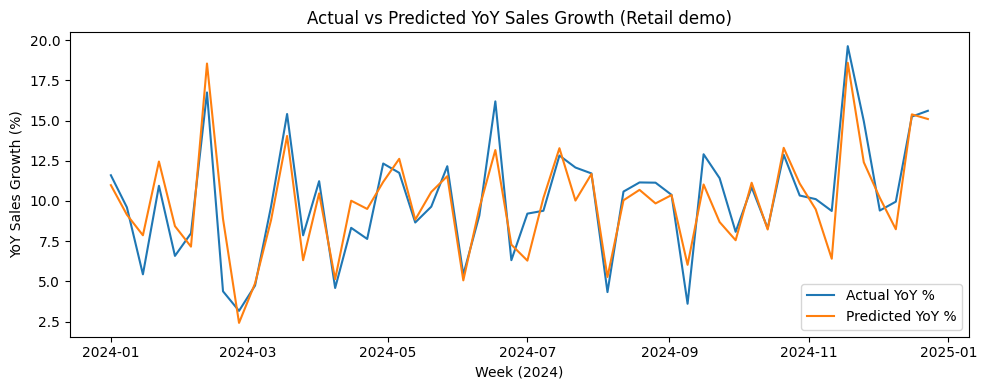

In [25]:

# ============================================================
# 6-1) Plot Actual vs Predicted YoY Sales Growth
# ============================================================
yoy_plot = yoy.copy()
yoy_plot["pred_dlog"] = model.predict(yoy_plot[feature_cols])
yoy_plot["actual_yoy_pct"] = (np.exp(yoy_plot["dlog_sales_yoy"]) - 1) * 100
yoy_plot["pred_yoy_pct"]   = (np.exp(yoy_plot["pred_dlog"]) - 1) * 100

plt.figure(figsize=(10,4))
plt.plot(yoy_plot["week"], yoy_plot["actual_yoy_pct"], label="Actual YoY %")
plt.plot(yoy_plot["week"], yoy_plot["pred_yoy_pct"], label="Predicted YoY %")
plt.xlabel("Week (2024)")
plt.ylabel("YoY Sales Growth (%)")
plt.title("Actual vs Predicted YoY Sales Growth (Retail demo)")
plt.legend()
plt.tight_layout()
plt.show()


### 6.2 Waterfall Chart: Driver Contributions <a class="anchor" id="62-waterfall-chart-driver-contributions"></a> 


Average YoY growth across 2024 (geometric) = 10.00%

DECOMPOSITION TABLE (allocated to 10.00pp for clean waterfall):
                Component  Contribution_Δlog  allocated_pp_out_of_10
0  Base/Other (Intercept)           0.045125                   4.735
1                   Media           0.024970                   2.620
2             Promo depth           0.008132                   0.853
3                   Price          -0.027507                  -2.886
4                  Stores           0.024555                   2.576
5                In-stock           0.009646                   1.012
6                    CSAT           0.009162                   0.961
7      Unknown (Residual)           0.001228                   0.129
8        Total (Observed)           0.095310                     NaN


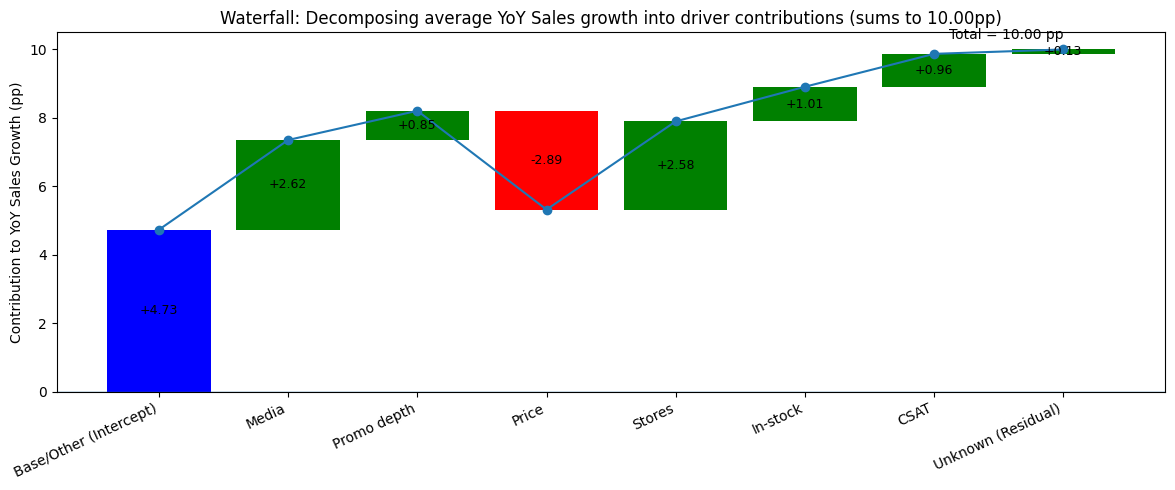

In [26]:
# ============================================================
# 6-2) Waterfall + table (allocated to 10.00pp for a clean story)
#    Color rule:
#      - green: positive contribution
#      - red: negative contribution
#      - blue: base
# ============================================================

# Exact add-up happens in Δlog. For a clean "10.00pp" waterfall,
# allocate by share of total Δlog (communication-friendly).
total_log = avg_actual_dlog
decomp["share_of_total"] = decomp["Contribution_Δlog"] / total_log
decomp["allocated_pp_out_of_10"] = decomp["share_of_total"] * 10.0
decomp.loc[decomp["Component"] == "Total (Observed)", "allocated_pp_out_of_10"] = np.nan

print(f"\nAverage YoY growth across 2024 (geometric) = {avg_actual_yoy_pct:.2f}%")
print("\nDECOMPOSITION TABLE (allocated to 10.00pp for clean waterfall):")
print(decomp[["Component","Contribution_Δlog","allocated_pp_out_of_10"]])

# Build waterfall series excluding the total row
wf = decomp[decomp["Component"] != "Total (Observed)"].copy()
labels = wf["Component"].tolist()
vals = wf["allocated_pp_out_of_10"].to_numpy()

cum = np.cumsum(vals)
starts = np.concatenate(([0], cum[:-1]))

# Colors as requested
colors = []
for lab, v in zip(labels, vals):
    if lab.startswith("Base/Other"):
        colors.append("blue")
    elif v >= 0:
        colors.append("green")
    else:
        colors.append("red")

plt.figure(figsize=(12,5))
plt.bar(np.arange(len(vals)), vals, bottom=starts, color=colors)
plt.axhline(0, linewidth=1)

# Cumulative line
plt.plot(np.arange(len(vals)), cum, marker="o")

# Annotate bar values
for i, v in enumerate(vals):
    plt.text(i, starts[i] + v/2, f"{v:+.2f}", ha="center", va="center", fontsize=9)

plt.text(len(vals)-1, cum[-1] + 0.3, f"Total = {cum[-1]:.2f} pp", ha="right", fontsize=10)

plt.xticks(np.arange(len(vals)), labels, rotation=25, ha="right")
plt.ylabel("Contribution to YoY Sales Growth (pp)")
plt.title("Waterfall: Decomposing average YoY Sales growth into driver contributions (sums to 10.00pp)")
plt.tight_layout()
plt.show()


Unknown / Residual is the portion of YoY growth not explained by modeled drivers. It captures:noise, unmodeled factors (competition, macro, weather, execution quality, etc.), any model misspecification. This residual is real in model space — it is not the log-to-percent conversion gap.

Unknown (Residual) calculatin: avg_unknown = avg_actual_dlog - (intercept + avg_contrib.sum())

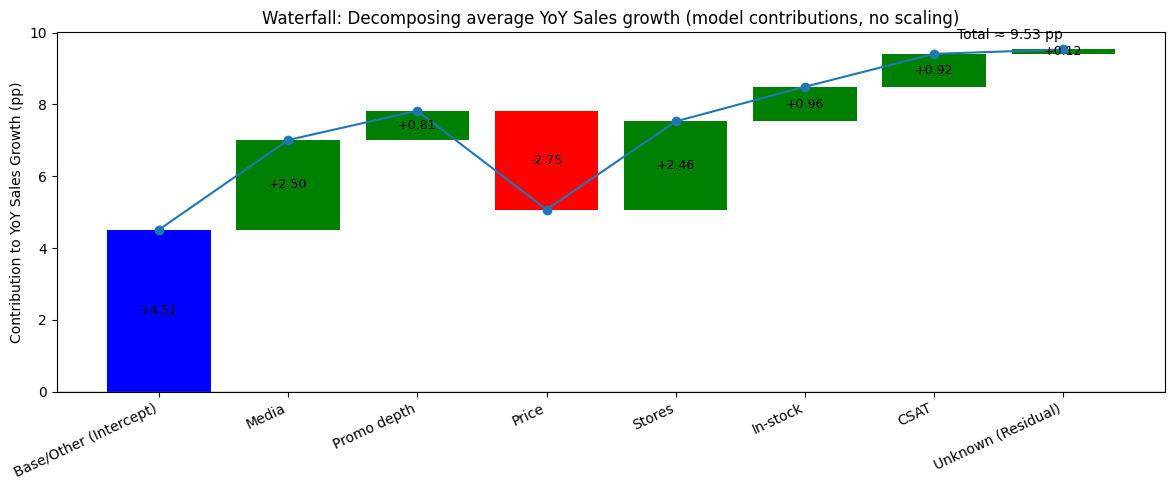

In [87]:
# --- Use the model's actual contributions (no scaling) ---
wf = decomp[decomp["Component"] != "Total (Observed)"].copy()

# Convert Δlog contributions to "pp-like" contributions
wf["pp"] = 100 * wf["Contribution_Δlog"]

labels = wf["Component"].tolist()
vals = wf["pp"].to_numpy()

cum = np.cumsum(vals)
starts = np.concatenate(([0], cum[:-1]))

# Colors: base blue, positive green, negative red
colors = []
for lab, v in zip(labels, vals):
    if lab.startswith("Base/Other"):
        colors.append("blue")
    elif v >= 0:
        colors.append("green")
    else:
        colors.append("red")

plt.figure(figsize=(12,5))
plt.bar(np.arange(len(vals)), vals, bottom=starts, color=colors)
plt.axhline(0, linewidth=1)

plt.plot(np.arange(len(vals)), cum, marker="o")

for i, v in enumerate(vals):
    plt.text(i, starts[i] + v/2, f"{v:+.2f}", ha="center", va="center", fontsize=9)

plt.text(len(vals)-1, cum[-1] + 0.3, f"Total ≈ {cum[-1]:.2f} pp", ha="right", fontsize=10)

plt.xticks(np.arange(len(vals)), labels, rotation=25, ha="right")
plt.ylabel("Contribution to YoY Sales Growth (pp)")
plt.title("Waterfall: Decomposing average YoY Sales growth (model contributions, no scaling)")
plt.tight_layout()
plt.show()


### 6.3 Accounting Table Allocation Chart <a class="anchor" id="63-accounting-table-allocation-chart"></a>

Text(0.5, 1.0, 'SALES GROWTH BY BUSINESS DRIVER (ALL)\nAverage YoY Decomposition')

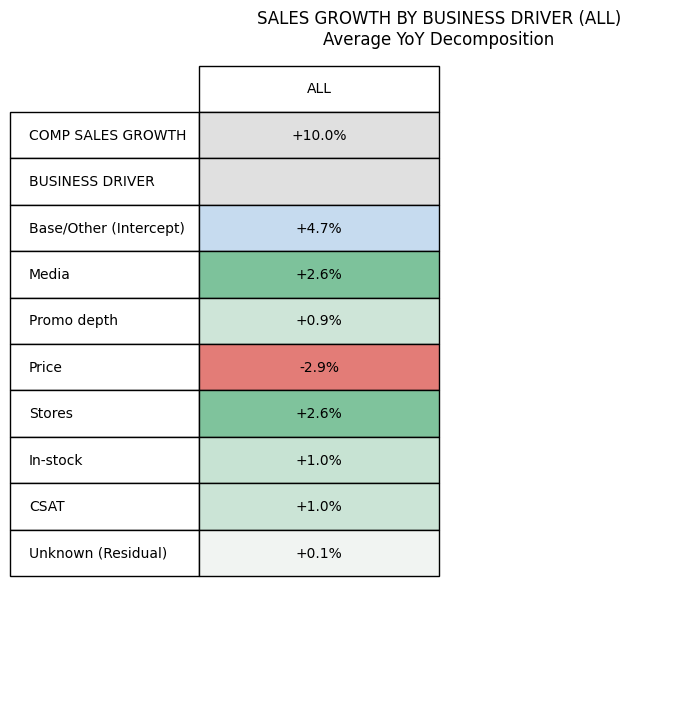

In [27]:
# 6-3 generate accounting table allocation chart
# ---- 1) Build the one-column table ----
drivers = (
    decomp[decomp["Component"] != "Total (Observed)"][["Component", "allocated_pp_out_of_10"]]
    .copy()
)
drivers = drivers.rename(columns={"allocated_pp_out_of_10": "ALL"})
drivers = drivers.set_index("Component")

total_pp = float(drivers["ALL"].sum())  # should be 10.00 in your allocation view

table_df = pd.concat([
    pd.DataFrame({"ALL": [total_pp]}, index=["COMP SALES GROWTH"]),
    pd.DataFrame({"ALL": [np.nan]}, index=["BUSINESS DRIVER"]),
    drivers
])

# ---- 2) Build cell text and colors (red/green; base row blue; headers grey) ----
row_labels = list(table_df.index)
vals = table_df["ALL"].to_numpy()

# color scale for drivers (exclude header rows)
driver_mask = ~np.isin(row_labels, ["COMP SALES GROWTH", "BUSINESS DRIVER"])
driver_vals = vals[driver_mask]
max_abs = max(1e-9, np.max(np.abs(driver_vals)))  # avoid divide by zero

norm = mcolors.TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)
cmap = mcolors.LinearSegmentedColormap.from_list(
    "red_white_green", ["#d73027", "#f7f7f7", "#1a9850"]
)

cell_text = []
cell_colors = []

for name, v in zip(row_labels, vals):
    if name in ["COMP SALES GROWTH", "BUSINESS DRIVER"]:
        cell_text.append(["" if pd.isna(v) else f"{v:+.1f}%"])
        cell_colors.append(["#e0e0e0"])
    elif str(name).startswith("Base/Other"):
        cell_text.append([f"{v:+.1f}%"])
        cell_colors.append(["#c6dbef"])  # light blue for base
    else:
        cell_text.append([f"{v:+.1f}%"])
        cell_colors.append([cmap(norm(v))])

# ---- 3) Render table ----
fig, ax = plt.subplots(figsize=(6.2, 8.5))
ax.axis("off")

tbl = ax.table(
    cellText=cell_text,
    rowLabels=row_labels,
    colLabels=["ALL"],
    cellColours=cell_colors,
    cellLoc="center",
    rowLoc="left",
    loc="upper center",
    bbox=[0.0, 0.2, 0.5, 0.78]
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.0, 1.35)

ax.set_title(
    "SALES GROWTH BY BUSINESS DRIVER (ALL)\nAverage YoY Decomposition",
    pad=6
)



Revenue
├── Transactions
│   ├── Channel mix shift
│   ├── Daypart mix shift
│   └── Within-segment transaction change
└── Ticket (AOV)
    ├── Base price level
    ├── Discount / promo depth (effective price)
    ├── Units per transaction (UPT)
    └── Product mix


Log model considenration

We use two complementary models. The elasticity model captures long-run structural relationships—why higher-investment markets tend to be larger. The growth decomposition model captures short-run dynamics—how year-over-year changes in drivers translate into year-over-year growth. Differences between the two are expected and highlight the distinction between structural potential and realized incremental impact.

Elasticity coefficients describe long-run structural sensitivity based on levels, while growth-decomposition coefficients describe short-run incremental sensitivity based on year-over-year changes.

Elasticity coefficient = Structural potential
“If we permanently ran this lever higher, how much bigger would the business be?”

Growth coefficient = Incremental potential
“If we change this lever relative to last year, how much will growth move this year?”


Elasticity = “how tall the ladder is”
Growth coefficient = “how much height you gain when you step up one rung”
Contribution = “how many rungs you actually climbed this year”

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

np.random.seed(2025)

In [30]:

# ============================================================
# Part 2) Level / Elasticity Model (log-levels)
# ============================================================
# Goal: show how a "level/elasticity" model differs from a YoY growth decomposition model.
# We'll generate a PANEL dataset (multiple markets) so a level model can pick up structural
# differences across markets, while the YoY growth model focuses on within-market changes.

# ----------------------------
# 1) Generate raw panel data
# ----------------------------
n_markets = 60
weeks = pd.date_range("2023-01-02", periods=104, freq="W-MON")
n_weeks = len(weeks)

panel = pd.MultiIndex.from_product([range(n_markets), weeks], names=["market_id", "week"]).to_frame(index=False)
panel["year"] = panel["week"].dt.year

# week index and week-of-year for seasonality
panel = panel.sort_values(["market_id","week"]).reset_index(drop=True)
panel["week_idx_global"] = (panel["week"] - panel["week"].min()).dt.days // 7
panel["woy"] = (panel["week_idx_global"] % 52) + 1
woy0 = (panel["woy"] - 1).to_numpy()
woy_idx = np.arange(52)

# seasonality (stable, repeats each year)
seasonality_by_woy = (
    0.12 * np.sin(2 * np.pi * woy_idx / 52) +
    0.08 * np.cos(2 * np.pi * woy_idx / 26)
)
holiday_bump = np.zeros(52)
holiday_bump[47] += 0.18
holiday_bump[25] += 0.07
seasonality_by_woy = seasonality_by_woy + holiday_bump

panel["seasonality"] = seasonality_by_woy[woy0]

# latent market factor (unobserved in the model) that drives both sales and media levels
brand_strength = np.random.normal(0, 1, n_markets)
panel["brand_strength"] = panel["market_id"].map({i: brand_strength[i] for i in range(n_markets)})

# store_count (market footprint) correlated with brand strength
stores_base = np.clip(80 + 20*brand_strength + np.random.normal(0, 8, n_markets), 40, 140)
store_growth = np.random.normal(0.03, 0.02, n_markets)  # ~3% YoY
panel["store_count"] = panel["market_id"].map({i: stores_base[i] for i in range(n_markets)})
panel.loc[panel["year"]==2024, "store_count"] = panel.loc[panel["year"]==2024, "market_id"].map(
    {i: int(np.round(stores_base[i]*np.exp(store_growth[i]))) for i in range(n_markets)}
)
panel["store_count"] = panel["store_count"].astype(int)
panel["log_stores"] = np.log(panel["store_count"])

# price_index (global inflation + small market noise)
inflation_trend = np.where(panel["year"].eq(2023), 0.0, 0.03)  # ~3% higher in 2024
panel["price_index"] = 1.00 + 0.006*np.cos(2*np.pi*woy0/52 - 0.2) + inflation_trend + np.random.normal(0, 0.003, len(panel))
panel["price_index"] = panel["price_index"].clip(0.95, 1.10)
panel["log_price"] = np.log(panel["price_index"])

# promo_depth (seasonal + mild market variation)
promo_base = 0.06 + 0.02*np.sin(2*np.pi*woy0/52 + 0.6)
promo_market = 0.004*panel["brand_strength"].to_numpy() + np.random.normal(0, 0.006, len(panel))
panel["promo_depth"] = (promo_base + promo_market).clip(0.0, 0.30)

# instock_rate and CSAT (bounded rates)
instock_base = 0.94 + 0.01*np.cos(2*np.pi*woy0/52 + 0.4)
panel["instock_rate"] = (instock_base + 0.006*panel["brand_strength"].to_numpy() + np.random.normal(0, 0.006, len(panel))).clip(0.85, 0.99)

csat_base = 0.82 + 0.01*np.sin(2*np.pi*woy0/52 - 0.5)
panel["customer_satisfaction_rate"] = (csat_base + 0.010*panel["brand_strength"].to_numpy() + np.random.normal(0, 0.007, len(panel))).clip(0.75, 0.95)

# media spend: strongly correlated with brand_strength (confounder), plus small YoY change
# We'll make the TRUE causal effect of media small, but level correlation large via brand_strength.
media_base_log = 12.0 + 0.90*panel["brand_strength"].to_numpy() + 0.35*panel["log_stores"].to_numpy()
media_season = 0.10*np.sin(2*np.pi*woy0/52)  # campaigns
media_yoy = np.where(panel["year"].eq(2023), 0.0, np.random.normal(0.01, 0.02, len(panel)))  # small YoY move
media_noise = np.random.normal(0, 0.10, len(panel))

panel["log_media"] = media_base_log + media_season + media_yoy + media_noise
panel["media_spend"] = np.maximum(0, np.round(np.exp(panel["log_media"]) - 1)).astype(int)
panel["log_media"] = np.log1p(panel["media_spend"])  # consistent transform used in modeling

# Generate sales (log-linear). True media effect is SMALL.
true = dict(
    b_media=0.06,     # small true incremental elasticity
    b_promo=0.90,
    b_price=-1.05,
    b_stores=0.55,
    b_instock=0.75,
    b_csat=0.55
)

noise = np.random.normal(0, 0.08, len(panel))  # more realistic noise for levels
base = 11.2
trend = 0.0002*panel["week_idx_global"].to_numpy()

# Unobserved brand_strength directly raises sales levels (omitted variable for pooled level regression)
panel["log_sales"] = (
    base
    + 0.85*panel["brand_strength"].to_numpy()
    + panel["seasonality"].to_numpy()
    + trend
    + true["b_media"] * panel["log_media"].to_numpy()
    + true["b_promo"] * panel["promo_depth"].to_numpy()
    + true["b_price"] * panel["log_price"].to_numpy()
    + true["b_stores"] * panel["log_stores"].to_numpy()
    + true["b_instock"] * panel["instock_rate"].to_numpy()
    + true["b_csat"] * panel["customer_satisfaction_rate"].to_numpy()
    + noise
)
panel["sales"] = np.exp(panel["log_sales"])

raw_cols = ["market_id","week","sales","media_spend","promo_depth","price_index","store_count","instock_rate","customer_satisfaction_rate"]
raw_panel = panel[raw_cols].copy()

print("RAW PANEL DATA (head):")
print(raw_panel.head(10))

RAW PANEL DATA (head):
   market_id       week     sales  media_spend  promo_depth  price_index  store_count  instock_rate  customer_satisfaction_rate
0          0 2023-01-02 5,987,808       692639     0.071700        1.004           85         0.945                       0.822
1          0 2023-01-09 6,782,927       674908     0.072557        1.005           85         0.946                       0.823
2          0 2023-01-16 7,278,574       724047     0.076046        1.012           85         0.947                       0.814
3          0 2023-01-23 6,417,917       719196     0.088375        1.004           85         0.940                       0.826
4          0 2023-01-30 7,472,062       761940     0.079730        1.005           85         0.956                       0.812
5          0 2023-02-06 5,621,724       675479     0.077409        1.005           85         0.945                       0.828
6          0 2023-02-13 5,864,517       655107     0.067963        1.007         

In [36]:
display(
    raw_panel[
        (raw_panel['market_id'].isin([0, 1])) &
        (raw_panel['week'] == pd.to_datetime('2023-01-02'))
    ]
)


,market_id,week,sales,media_spend,promo_depth,price_index,store_count,instock_rate,customer_satisfaction_rate
0,0,2023-01-02,"5,987,808",692639,0.071700,1.004,85,0.945,0.822
104,1,2023-01-02,"13,052,118",1375971,0.064311,1.005,86,0.955,0.819


In [35]:
print(raw_panel['market_id'].value_counts())
print(len(raw_panel))


market_id
0     104
1     104
2     104
3     104
4     104
5     104
6     104
7     104
8     104
9     104
10    104
11    104
12    104
13    104
14    104
15    104
16    104
17    104
18    104
19    104
20    104
21    104
22    104
23    104
24    104
25    104
26    104
27    104
28    104
29    104
30    104
31    104
32    104
33    104
34    104
35    104
36    104
37    104
38    104
39    104
40    104
41    104
42    104
43    104
44    104
45    104
46    104
47    104
48    104
49    104
50    104
51    104
52    104
53    104
54    104
55    104
56    104
57    104
58    104
59    104
Name: count, dtype: int64
6240


In [31]:

# ---------------------------------------
# 2) Feature engineering for LEVEL model
# ---------------------------------------
df = raw_panel.copy()
df["year"] = df["week"].dt.year
df = df.sort_values(["market_id","week"]).reset_index(drop=True)

df["week_idx_global"] = (df["week"] - df["week"].min()).dt.days // 7
df["woy"] = (df["week_idx_global"] % 52) + 1
df["seasonality"] = seasonality_by_woy[(df["woy"]-1).to_numpy()]

df["log_sales"]  = np.log(df["sales"])
df["log_media"]  = np.log1p(df["media_spend"])
df["log_price"]  = np.log(df["price_index"])
df["log_stores"] = np.log(df["store_count"])

print("\nENGINEERED (LEVEL) DATASET (head):")
print(df[["market_id","week","year","woy","seasonality","sales","log_sales","media_spend","log_media"]].head(10))


ENGINEERED (LEVEL) DATASET (head):
   market_id       week  year  woy  seasonality     sales  log_sales  media_spend  log_media
0          0 2023-01-02  2023    1     0.080000 5,987,808         16       692639         13
1          0 2023-01-09  2023    2     0.092140 6,782,927         16       674908         13
2          0 2023-01-16  2023    3     0.099554 7,278,574         16       724047         13
3          0 2023-01-23  2023    4        0.102 6,417,917         16       719196         13
4          0 2023-01-30  2023    5        0.101 7,472,062         16       761940         14
5          0 2023-02-06  2023    6     0.096536 5,621,724         16       675479         13
6          0 2023-02-13  2023    7     0.089218 5,864,517         16       655107         13
7          0 2023-02-20  2023    8     0.080178 6,957,291         16       786334         14
8          0 2023-02-27  2023    9     0.070390 6,383,255         16       873052         14
9          0 2023-03-06  2023   10

In [32]:

# ---------------------------------------
# 3) Train/test split (time-based)
# ---------------------------------------
df_2024 = df[df["year"]==2024].copy()
cut_date = df_2024["week"].sort_values().unique()[40]  # after 40 weeks

train = df[(df["year"]==2023) | ((df["year"]==2024) & (df["week"] < cut_date))].copy()
test  = df[(df["year"]==2024) & (df["week"] >= cut_date)].copy()

level_features = ["log_media","promo_depth","log_price","log_stores","instock_rate","customer_satisfaction_rate","seasonality"]
target = "log_sales"

X_train, y_train = train[level_features], train[target]
X_test, y_test   = test[level_features],  test[target]

# sklearn model (prediction/eval)
lr = LinearRegression()
lr.fit(X_train, y_train)

yhat_train = lr.predict(X_train)
yhat_test  = lr.predict(X_test)

def rmse(a, b): 
    return float(np.sqrt(mean_squared_error(a, b)))

eval_table = pd.DataFrame({
    "Split": ["Train","Test"],
    "RMSE (log sales)": [rmse(y_train, yhat_train), rmse(y_test, yhat_test)],
    "MAE (log sales)": [float(mean_absolute_error(y_train, yhat_train)), float(mean_absolute_error(y_test, yhat_test))],
    "R^2": [float(r2_score(y_train, yhat_train)), float(r2_score(y_test, yhat_test))],
})

# translate log error to approx % error (multiplicative)
eval_table["RMSE (~% error)"] = (np.exp(eval_table["RMSE (log sales)"]) - 1) * 100
eval_table["MAE (~% error)"]  = (np.exp(eval_table["MAE (log sales)"]) - 1) * 100

print("\nLEVEL MODEL EVALUATION:")
print(eval_table.round(3))


LEVEL MODEL EVALUATION:
   Split  RMSE (log sales)  MAE (log sales)   R^2  RMSE (~% error)  MAE (~% error)
0  Train             0.126            0.100 0.984               13              11
1   Test             0.127            0.101 0.984               14              11


In [33]:

# ---------------------------------------
# 4) Coefficient table with p-values (statsmodels)
# ---------------------------------------
# Pooled OLS (no market FE) -> shows confounded "structural" level relationship
ols_train = sm.OLS(y_train, sm.add_constant(X_train)).fit()
coef_table = pd.DataFrame({
    "Term": ols_train.params.index,
    "Coefficient": ols_train.params.values,
    "Std. Error": ols_train.bse.values,
    "t-stat": ols_train.tvalues.values,
    "p-value": ols_train.pvalues.values
})
print("\nLEVEL / ELASTICITY MODEL COEFFICIENTS (Pooled OLS on TRAIN):")
print(coef_table.round(4))

# (Optional but educational) Market Fixed Effects (removes time-invariant market confounding)
fe_formula = "log_sales ~ log_media + promo_depth + log_price + log_stores + instock_rate + customer_satisfaction_rate + seasonality + C(market_id)"
fe_model = smf.ols(fe_formula, data=train).fit()

print("\nLEVEL MODEL WITH MARKET FIXED EFFECTS (TRAIN) — key coefficients only:")
print(fe_model.params[["log_media","promo_depth","log_price","log_stores","instock_rate","customer_satisfaction_rate","seasonality"]].round(4))


LEVEL / ELASTICITY MODEL COEFFICIENTS (Pooled OLS on TRAIN):
                         Term  Coefficient  Std. Error  t-stat  p-value
0                       const       -3.072       0.279     -11 0.000000
1                   log_media        0.923    0.005300     173 0.000000
2                 promo_depth       -1.613       0.148     -11 0.000000
3                   log_price       -1.414       0.117     -12 0.000000
4                  log_stores        0.435    0.015400      28 0.000000
5                instock_rate        3.516       0.218      16 0.000000
6  customer_satisfaction_rate        1.359       0.217   6.274 0.000000
7                 seasonality        0.766    0.023200      33 0.000000

LEVEL MODEL WITH MARKET FIXED EFFECTS (TRAIN) — key coefficients only:
log_media                    0.055100
promo_depth                     0.714
log_price                      -0.723
log_stores                      0.498
instock_rate                    0.468
customer_satisfaction_rate  

In [37]:
# ---------------------------------------
# 5) Scenario interpretation (elasticities)
# ---------------------------------------
beta = pd.Series(ols_train.params, index=ols_train.params.index)

scenarios = [
    ("log_media", "Media +10%", np.log(1.10)),
    ("log_price", "Price +1%",  np.log(1.01)),
    ("log_stores","Stores +5%", np.log(1.05)),
    ("promo_depth","Promo depth +5pp", 0.05),
    ("instock_rate","In-stock +1pp", 0.01),
    ("customer_satisfaction_rate","CSAT +1pp", 0.01),
]

rows = []
for term, label, delta in scenarios:
    impact_log = beta[term] * delta
    impact_pct = 100*(np.exp(impact_log) - 1)
    rows.append([term, label, beta[term], impact_log, impact_pct])

scenario_table = pd.DataFrame(rows, columns=["Feature","Scenario","Coefficient","Impact on log(Sales)","Impact on Sales (%)"])
print("\nLEVEL MODEL: SCENARIO-BASED IMPACTS (Pooled OLS):")
print(scenario_table.round(4))


LEVEL MODEL: SCENARIO-BASED IMPACTS (Pooled OLS):
                      Feature          Scenario  Coefficient  Impact on log(Sales)  Impact on Sales (%)
0                   log_media        Media +10%        0.923              0.088000                9.196
1                   log_price         Price +1%       -1.414             -0.014100               -1.397
2                  log_stores        Stores +5%        0.435              0.021200                2.144
3                 promo_depth  Promo depth +5pp       -1.613             -0.080600               -7.747
4                instock_rate     In-stock +1pp        3.516              0.035200                3.579
5  customer_satisfaction_rate         CSAT +1pp        1.359              0.013600                1.369


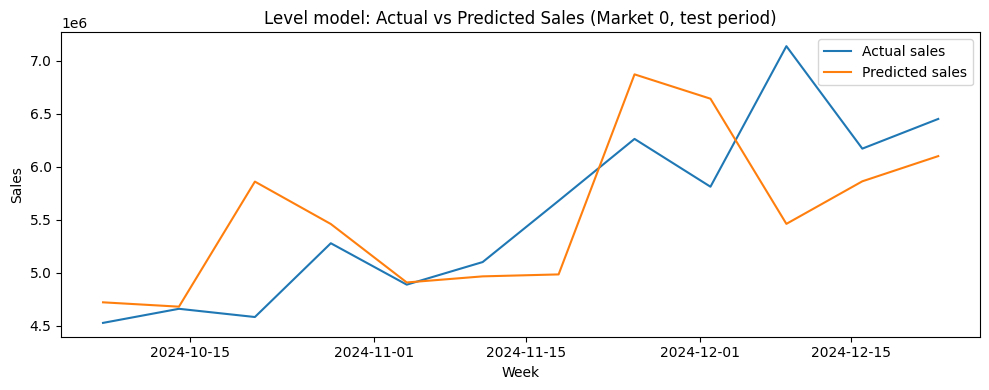

In [38]:

# ---------------------------------------
# 6) Plot Actual vs Predicted (levels) for one market in test period
# ---------------------------------------
test_pred = test.copy()
test_pred["pred_log_sales"] = lr.predict(test[level_features])
test_pred["pred_sales"] = np.exp(test_pred["pred_log_sales"])

m = 0
plot_df = test_pred[test_pred["market_id"]==m].copy()

plt.figure(figsize=(10,4))
plt.plot(plot_df["week"], plot_df["sales"], label="Actual sales")
plt.plot(plot_df["week"], plot_df["pred_sales"], label="Predicted sales")
plt.title(f"Level model: Actual vs Predicted Sales (Market {m}, test period)")
plt.xlabel("Week")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

In [39]:

# ---------------------------------------
# 7) Fit the Growth Decomposition model (Δlog) on same data for comparison
# ---------------------------------------
g = df.sort_values(["market_id","week"]).copy()

lag = 52
for c in ["log_sales","log_media","promo_depth","log_price","log_stores","instock_rate","customer_satisfaction_rate"]:
    g[f"{c}_lag52"] = g.groupby("market_id")[c].shift(lag)

g["dlog_sales_yoy"] = g["log_sales"] - g["log_sales_lag52"]
g["dlog_media"] = g["log_media"] - g["log_media_lag52"]
g["d_promo"] = g["promo_depth"] - g["promo_depth_lag52"]
g["dlog_price"] = g["log_price"] - g["log_price_lag52"]
g["dlog_stores"] = g["log_stores"] - g["log_stores_lag52"]
g["d_instock"] = g["instock_rate"] - g["instock_rate_lag52"]
g["d_csat"] = g["customer_satisfaction_rate"] - g["customer_satisfaction_rate_lag52"]

yoy = g[g["year"]==2024].dropna(subset=["dlog_sales_yoy"]).copy()

growth_features = ["dlog_media","d_promo","dlog_price","dlog_stores","d_instock","d_csat"]
growth_target = "dlog_sales_yoy"

weeks_2024 = sorted(yoy["week"].unique())
cut_date_2024 = weeks_2024[40]

train_g = yoy[yoy["week"] < cut_date_2024].copy()
ols_g = sm.OLS(train_g[growth_target], sm.add_constant(train_g[growth_features])).fit()

print("\nGROWTH MODEL COEFFICIENTS (Δlog model, TRAIN):")
print(pd.DataFrame({"Coefficient": ols_g.params}).round(4))


GROWTH MODEL COEFFICIENTS (Δlog model, TRAIN):
             Coefficient
const          -0.006000
dlog_media      0.049200
d_promo            0.335
dlog_price        -0.496
dlog_stores        0.529
d_instock          0.555
d_csat             0.313


In [40]:

# ---------------------------------------
# 8) Compare coefficients: Level vs Growth (and FE-corrected level)
# ---------------------------------------
compare = pd.DataFrame({
    "Driver": ["Media","Promo","Price","Stores","In-stock","CSAT"],
    "Level model term": ["log_media","promo_depth","log_price","log_stores","instock_rate","customer_satisfaction_rate"],
    "Growth model term": ["dlog_media","d_promo","dlog_price","dlog_stores","d_instock","d_csat"],
    "Level coef (pooled OLS)": [
        ols_train.params["log_media"],
        ols_train.params["promo_depth"],
        ols_train.params["log_price"],
        ols_train.params["log_stores"],
        ols_train.params["instock_rate"],
        ols_train.params["customer_satisfaction_rate"]
    ],
    "Level coef (market FE)": [
        fe_model.params["log_media"],
        fe_model.params["promo_depth"],
        fe_model.params["log_price"],
        fe_model.params["log_stores"],
        fe_model.params["instock_rate"],
        fe_model.params["customer_satisfaction_rate"]
    ],
    "Growth coef (Δlog)": [
        ols_g.params["dlog_media"],
        ols_g.params["d_promo"],
        ols_g.params["dlog_price"],
        ols_g.params["dlog_stores"],
        ols_g.params["d_instock"],
        ols_g.params["d_csat"]
    ],
})

print("\nCOEFFICIENT COMPARISON:")
print(compare.round(4))


COEFFICIENT COMPARISON:
     Driver            Level model term Growth model term  Level coef (pooled OLS)  Level coef (market FE)  Growth coef (Δlog)
0     Media                   log_media        dlog_media                    0.923                0.055100            0.049200
1     Promo                 promo_depth           d_promo                   -1.613                   0.714               0.335
2     Price                   log_price        dlog_price                   -1.414                  -0.723              -0.496
3    Stores                  log_stores       dlog_stores                    0.435                   0.498               0.529
4  In-stock                instock_rate         d_instock                    3.516                   0.468               0.555
5      CSAT  customer_satisfaction_rate            d_csat                    1.359                   0.426               0.313
